# Learning convolutional kernels using biologically-inspired BTSP

In [2]:
import torch
import matplotlib.pyplot as plt
import EIANN.plot as pt

from tqdm.autonotebook import tqdm
import numpy as np
import matplotlib.gridspec as gs
%load_ext autoreload
%autoreload 2

pt.update_plot_defaults()




/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [175]:
# Load MNIST data
import torchvision
from torchvision import transforms
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False, transform=transforms.ToTensor())
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=False, download=False, transform=transforms.ToTensor())

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(MNIST_train_dataset, batch_size=1, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(MNIST_test_dataset, batch_size=10000, shuffle=False)

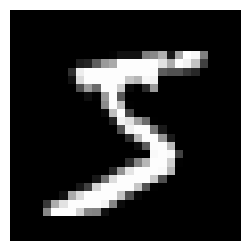

In [4]:
# plot example image
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.imshow(MNIST_train_dataset[0][0][0], cmap='gray')
ax.axis('off')
plt.show()

## Standard CNN

In [220]:
torch.manual_seed(0)

# Simple convolutional network in PyTorch
class CNN(torch.nn.Module):
    def __init__(self, kernel_size=5, num_conv_filters=32):
        super(CNN, self).__init__()
        original_image_dim = 28
        dim_after_maxpool = original_image_dim // 2
        num_output_classes = 10
        self.conv1 = torch.nn.Conv2d(1, num_conv_filters, kernel_size=kernel_size, padding=2)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(num_conv_filters*dim_after_maxpool*dim_after_maxpool, num_output_classes)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, 32*14*14)
        x = self.fc1(x)
        return x
    
cnn = CNN(kernel_size=5, num_conv_filters=32)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

Accuracy of the network on the 10,000 test images: 10.07%


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/60000 [00:00<?, ?it/s]

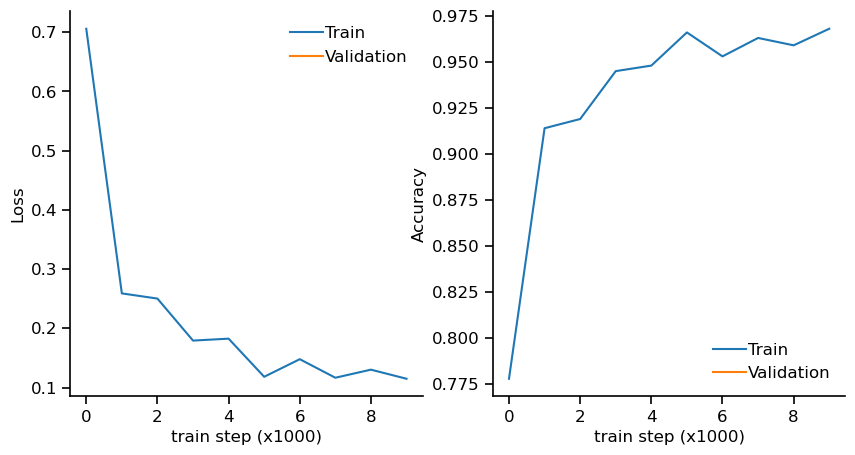

Accuracy of the network on the 10,000 test images: 96.21%


In [221]:
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Test the network
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = cnn(images)
        correct += (outputs.argmax(1) == labels).float().sum().item()
        total += labels.size(0)
print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total:.2f}%')


# Train the network
n_epochs = 1
max_steps = 10000

for epoch in tqdm(range(n_epochs)):
    running_loss = []
    running_train_accuracy = []
    for i, data in tqdm(enumerate(train_dataloader, 0), leave=False, total=len(train_dataloader), desc=f'Epoch {epoch+1}/{n_epochs}'):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        running_train_accuracy.append((outputs.argmax(1) == labels))
        if i % 1000 == 999: # print every 1000 mini-batches
            train_loss.append(np.mean(running_loss))
            train_accuracy.append(np.mean(running_train_accuracy))
            running_loss = []
            running_train_accuracy = []
        if i >= max_steps:
            break
        
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        val_loss.append(loss.item())
        val_accuracy.append((outputs.argmax(1) == labels).float().mean().item())

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_loss, label='Train')
ax[0].plot(val_loss, label='Validation')
ax[0].set_xlabel('train step (x1000)')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(train_accuracy, label='Train')
ax[1].plot(val_accuracy, label='Validation')
ax[1].set_xlabel('train step (x1000)')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

# Test the network
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = cnn(images)
        correct += (outputs.argmax(1) == labels).float().sum().item()
        total += labels.size(0)
print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total:.2f}%')

# # Save the network
# torch.save(cnn.state_dict(), 'cnn.pth')

# # Load the network
# cnn = CNN()
# cnn.load_state_dict(torch.load('cnn.pth'))

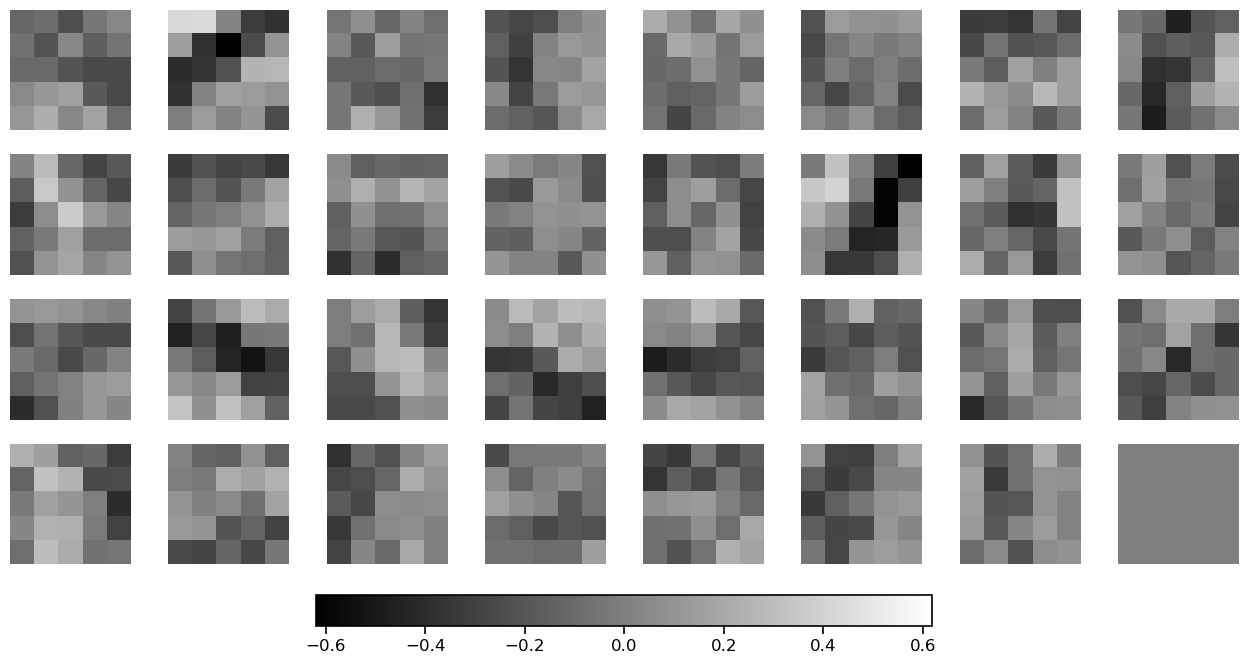

In [223]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))   
conv1 = cnn.conv1.weight.detach().numpy()
max_val = np.max(np.abs(conv1))
for i,kernel in enumerate(conv1):
    ax = axes[i%4, i//4]
    ax.imshow(kernel[0,:,:], cmap='gray', interpolation='none', vmin=-max_val, vmax=max_val)
    ax.axis('off')
cbar = fig.colorbar(ax.imshow(np.zeros((5,5)), cmap='gray', vmin=-max_val, vmax=max_val), ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
plt.show()

## BTSP

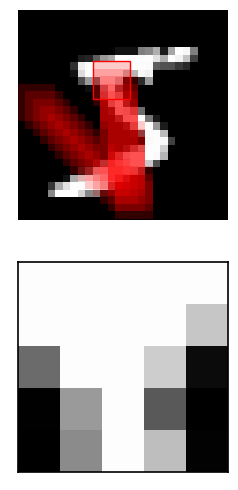

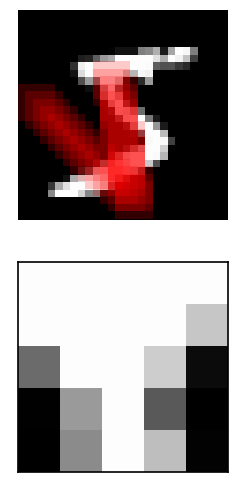

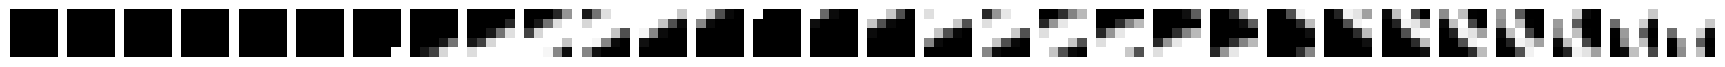

In [5]:
from IPython.display import clear_output, display

def saccade(image, start_x, start_y, kernel_size, saccade_angle, saccade_length):
    '''
    Move the convolutional kernel (receptive field) with a saccade of a given and angle.
    '''
    x = start_x # x-coordinate of the top left corner of the receptive field
    y = start_y # y-coordinate of the top left corner of the receptive field
    saccade_angle = np.deg2rad(-saccade_angle)
    image_timeseries = []

    fig, ax = plt.subplots(2, 1, figsize=(6,6))
    ax[0].imshow(image, cmap='gray')
    
    # Move the receptive field one pixel at a time
    while len(image_timeseries) < saccade_length:
        while 0 <= x < image.shape[0]-kernel_size and 0 <= y < image.shape[1]-kernel_size:
            # Get the receptive field
            x_approx = round(x)
            y_approx = round(y)
            receptive_field = image[y_approx:y_approx+kernel_size, x_approx:x_approx+kernel_size]
            image_timeseries.append(receptive_field)

            # interactively plot a square around the receptive field, clearing in every iteration and making a new plot
            clear_output(wait=True)
            filled_square = plt.Rectangle((x_approx-0.6, y_approx-0.6), kernel_size, kernel_size, linewidth=1, edgecolor='none', facecolor='r', alpha=1/kernel_size)
            ax[0].add_patch(filled_square)
            empty_square = plt.Rectangle((x_approx-0.6, y_approx-0.6), kernel_size, kernel_size, linewidth=1, edgecolor='r', facecolor='none')
            ax[0].add_patch(empty_square)
            ax[0].axis('off')
            
            ax[1].cla()
            ax[1].imshow(receptive_field, cmap='gray', vmin=image.min(), vmax=image.max())
            ax[1].set_xticks([])
            ax[1].set_yticks([])
            ax[1].spines['top'].set_visible(True)
            ax[1].spines['right'].set_visible(True)
            display(fig)        
            empty_square.remove()

            # Move the receptive field
            x += np.cos(saccade_angle)
            y += np.sin(saccade_angle)
            if x_approx==round(x) and y_approx==round(y): # if the saccade didn't move the receptive field, take another step in the same direction
                x += np.cos(saccade_angle)
                y += np.sin(saccade_angle)
            
            if len(image_timeseries) >= saccade_length:
                break

        # Change the saccade angle, picking 
        saccade_angle += np.pi + np.random.uniform(-np.pi/2, np.pi/2)
        saccade_angle = saccade_angle % (2*np.pi) # keep the angle between 0 and 2*pi
        x = x_approx + np.cos(saccade_angle)
        y = y_approx + np.sin(saccade_angle)

    return image_timeseries

np.random.seed(123)
image = MNIST_train_dataset[0][0][0].numpy()
start_x = 0  #np.random.randint(0, image.shape[0]-kernel_size) # x-coordinate of the top left corner of the receptive field
start_y = 10 #np.random.randint(0, image.shape[1]-kernel_size) # y-coordinate of the top left corner of the receptive field
saccade_angle = -45
kernel_size = 5
saccade_length = 30
image_timeseries = saccade(image, start_x, start_y, kernel_size, saccade_angle, saccade_length)

fig, ax = plt.subplots(1, len(image_timeseries), figsize=(22, 5))
for i,im in enumerate(image_timeseries):
    ax[i].imshow(im, cmap='gray')
    ax[i].axis('off')

In [6]:
# BTSP learning rule

def get_BTSP_function(Wmax, k_pot, k_dep, sig_pot, sig_dep):
    '''
    Returns a callable function that computes the BTSP weight update as a function of the current synaptic weight and
    the overlap between eligibility traces and instructive signals.
    The BTSP function is parameterized by the maximum synaptic weight and sigmoid functions for potentiation and
    depression (scaled by potentiation and depression coefficients).
    '''
    dW = lambda ETxIS, W: (Wmax - W) * k_pot * sig_pot(ETxIS) - W * k_dep * sig_dep(ETxIS)
    return dW

def get_scaled_sigmoid(slope, threshold):
    '''
    Returns a callable function for a scaled sigmoid with the given slope and threshold.
    The sigmoid is scaled so that it goes from 0 to 1 for x in [0,1]
    '''
    peak =  1. / (1. + np.exp(-slope * (1 - threshold)))    # value of sigmoid at x=1
    baseline = 1. / (1. + np.exp(-slope * (0 - threshold))) # value of sigmoid at x=0
    scaled_sigmoid = lambda x: (1. / (1. + np.exp(-slope * (x - threshold))) - baseline) / (peak-baseline)
    return scaled_sigmoid

# BTSP parameters from (Milstein et al., 2021, eLife) Fig.7
sig_pot = get_scaled_sigmoid(slope=4.405, threshold=0.415)
sig_dep = get_scaled_sigmoid(slope=20.0, threshold=0.026)
k_dep = 0.425
k_pot = 1.1097
Wmax = 4.68
btsp_func = get_BTSP_function(Wmax, k_pot, k_dep, sig_pot, sig_dep)

ET_rise_tau=0.3
IS_rise_tau=0.05
ET_decay_tau=1.66
IS_decay_tau=0.44


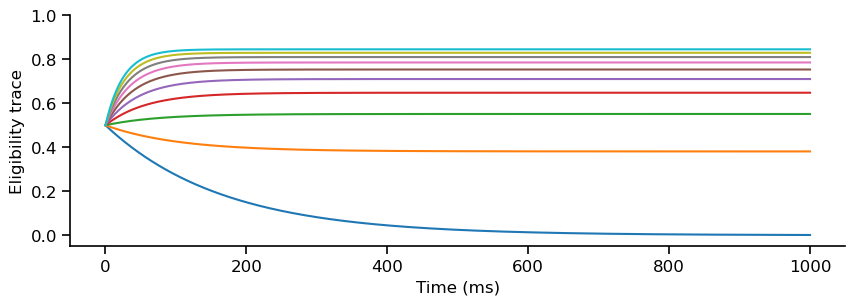

In [224]:
for input in np.linspace(0,1,10):
    ET_init = 0.5
    dt = 0.01
    ET_list = [ET_init] 
    for t in range (1000):
        ET = ET_list[-1]
        dET_rise = (1-ET)*(1-np.exp(-dt*input/(ET_rise_tau)))
        dET_decay = ET*(1-np.exp(-dt/ET_decay_tau))
        dET = dET_rise - dET_decay
        ET_list.append(ET+dET)

    plt.plot(ET_list)
plt.ylim(-0.05,1)
plt.xlabel('Time (ms)')
plt.ylabel('Eligibility trace')
plt.show()

Frame rate: 10.0 Hz


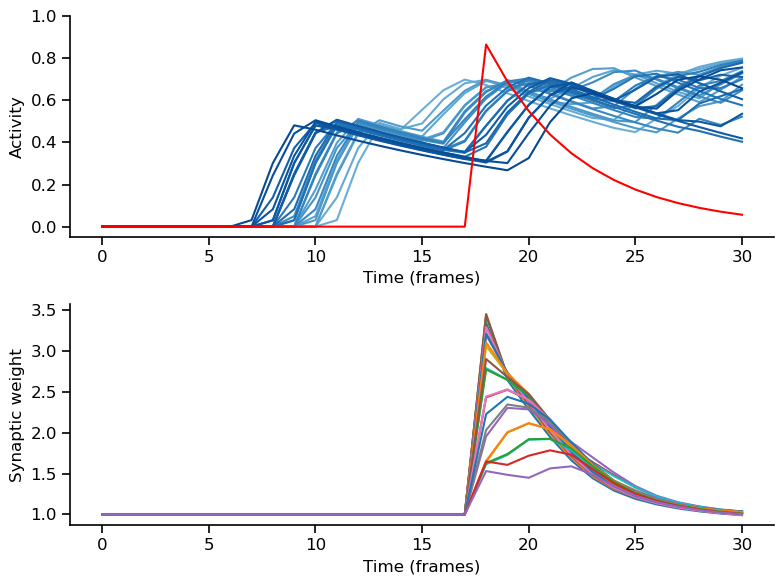

In [225]:
np.random.seed(123)
num_conv_filters = 32

# Initialize ET/IS and weight matrices
kernel_weights = np.ones([num_conv_filters, kernel_size, kernel_size])
# kernel_weights = np.random.rand(5, 5)

# Set runtime parameters
dt = 0.1  # s (dwell time of the receptive field kernel at each location)
framerate = 1/dt  # Hz
print(f'Frame rate: {framerate} Hz')

IS = np.zeros(num_conv_filters)
ET = np.zeros(kernel_size*kernel_size)
ET_history = [np.copy(ET)]
IS_history = [np.copy(IS)]
weights_history = [np.copy(kernel_weights.flatten())]

for t,image in enumerate(image_timeseries):
    # Compute eligibility trace
    dET_rise = (1-ET)*(1-np.exp(-dt*image.flatten()/(ET_rise_tau)))
    dET_decay = ET*(1-np.exp(-dt/ET_decay_tau))
    ET += dET_rise - dET_decay
    ET_history.append(np.copy(ET))
    
    # Compute instructive signal
    plateau_probability = 0.05
    plateaus = np.random.rand(num_conv_filters) < plateau_probability
    dIS_rise = (1-IS)*(1-np.exp(-dt*plateaus/IS_rise_tau))
    dIS_decay = IS*(1-np.exp(-dt/IS_decay_tau))
    IS += dIS_rise - dIS_decay
    IS_history.append(np.copy(IS))

    # Compute weight update
    ETxIS = np.outer(IS,ET).flatten()
    dW = btsp_func(ETxIS, kernel_weights.flatten())
    kernel_weights += dW.reshape(num_conv_filters, kernel_size, kernel_size)
    weights_history.append(np.copy(kernel_weights.flatten()))

ET_history = np.array(ET_history)
IS_history = np.array(IS_history)
weights_history = np.array(weights_history)

# Generate plots

cell_nr = 3

fig, axes = plt.subplots(2, 1, figsize=(8, 6))
ax = axes[0]
colors_ET = plt.cm.Blues(np.linspace(0.5,0.9,ET_history.shape[1]))
for i in range(ET_history.shape[1]):
    ax.plot(ET_history[:,i], color=colors_ET[i])
# colors_IS = plt.cm.Reds( np.linspace(0.5,0.9,IS_history.shape[1]))
# for i in range(IS_history.shape[1]):
#     ax.plot(IS_history[:,i], color=colors_IS[i])
# ax.plot(ET_history, color='b')
ax.plot(IS_history[:,cell_nr], color='r')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Activity')
ax.set_ylim(-0.05,1) 

ax = axes[1]
weights_history = np.array(weights_history).reshape(-1, num_conv_filters, kernel_size*kernel_size)
ax.plot(weights_history[:,cell_nr])
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Synaptic weight')

plt.tight_layout()
plt.show()

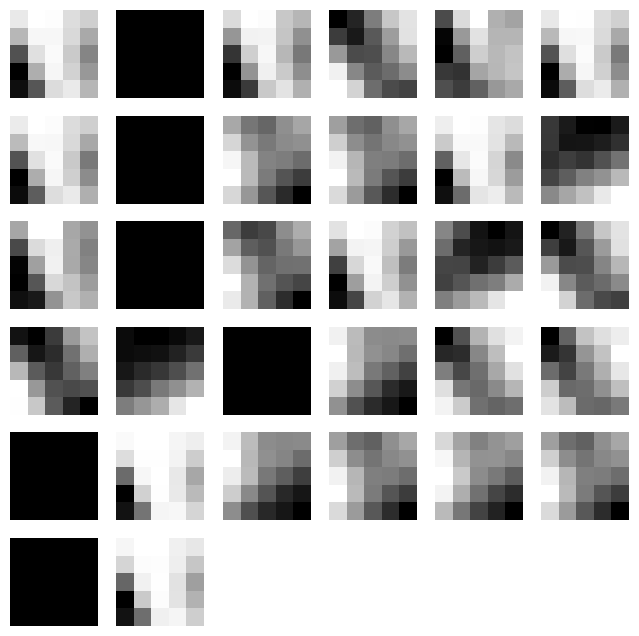

In [226]:
num_rows = int(np.ceil(np.sqrt(num_conv_filters)))
num_cols = int(np.ceil(num_conv_filters / num_rows))
fig, ax = plt.subplots(num_rows, num_cols, figsize=(8, 8))
for i in range(len(ax.flatten())):
    if i < num_conv_filters:
        ax.flatten()[i].imshow(kernel_weights[i], cmap='gray')
    ax.flatten()[i].axis('off')
plt.show()

In [150]:
cnn = CNN(kernel_size=5)
cnn.conv1.weight.data

tensor([[[[ 1.9537e-01,  1.8520e-02, -6.3772e-02,  2.1816e-02,  6.0585e-02],
          [ 3.8751e-02, -1.2756e-01, -5.1520e-02,  1.8512e-01, -7.2857e-02],
          [-7.9351e-02,  1.3103e-01,  5.1611e-02,  1.6568e-01, -1.5989e-01],
          [-8.3134e-02,  6.3378e-02,  6.6266e-02,  1.3072e-01, -9.1383e-02],
          [-1.7996e-01, -9.8010e-02, -7.0198e-02, -1.0411e-02,  1.8404e-01]]],


        [[[-6.9164e-02,  7.8428e-02, -6.0997e-02,  1.9895e-02,  1.5227e-01],
          [ 2.0821e-02, -2.2140e-02,  2.5462e-02,  9.9723e-02, -1.6932e-01],
          [-1.7954e-01, -1.5644e-02, -1.8732e-01, -6.0436e-02,  1.7278e-02],
          [-9.0515e-02, -9.1936e-02, -1.0069e-01,  1.1329e-01, -2.6575e-02],
          [ 2.4955e-02, -1.7486e-01, -1.9539e-01, -8.3564e-02,  6.3805e-02]]],


        [[[-8.6019e-02,  3.6838e-02,  1.9151e-01,  5.6615e-02, -1.0019e-01],
          [ 1.7739e-01,  1.6883e-01,  1.7733e-01, -1.0132e-01, -1.6998e-01],
          [-7.6314e-02, -2.6243e-02, -2.8440e-02,  1.1719e-01, -2.82